In [1]:
import pandas as pd
from pathlib import Path
import sys
import numpy as np

sys.path.append(str(Path().resolve().parent))
from data_preprocessing.preprocessing import preprocessing
from eda_ftr_eng.EDA import eda


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.1.2 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.10_3.10.3056.0_x64__qbz5n2kfra8p0\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.10_3.10.3056.0_x64__qbz5n2kfra8p0\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "C:\Users\eilee\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\ipykernel_l

AttributeError: _ARRAY_API not found


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.1.2 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.10_3.10.3056.0_x64__qbz5n2kfra8p0\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.10_3.10.3056.0_x64__qbz5n2kfra8p0\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "C:\Users\eilee\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\ipykernel_l

AttributeError: _ARRAY_API not found

In [2]:
df_raw = pd.read_csv('../Data/Raw/Job_Frauds.csv', encoding='latin-1')
preprocessed_df = preprocessing(df_raw)

C:\Users\eilee\OneDrive - National University of Singapore\DSA4263\DSA4263-Project\data_preprocessing\preprocessing.py:27: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: x.lower() if isinstance(x, str) else x)


In [3]:
preprocessed_df['Profile']

0        food52 weve created groundbreaking awardwinnin...
1        90 second world cloud video production service...
2        valor service provides workforce solution meet...
3        passion improving quality life geography heart...
4        spotsource solution llc global human capital m...
                               ...                        
17875    vend looking awesome new talent come join u yo...
17876    weblinc ecommerce platform service provider fa...
17877    provide full time permanent position many medi...
17878                                              unknown
17879    vend looking awesome new talent come join u yo...
Name: Profile, Length: 17880, dtype: object

In [4]:
df = eda(preprocessed_df)

In [5]:
df.columns

Index(['Job Title', 'Department', 'Range_of_Salary', 'Profile',
       'Job_Description', 'Requirements', 'Job_Benefits', 'Telecomunication',
       'Comnpany_Logo', 'Type_of_Employment', 'Experience', 'Qualification',
       'Type_of_Industry', 'Operations', 'Fraudulent', 'City',
       'Salary_Specified', 'City_Specified'],
      dtype='object')

## Feature Engineering: Converting text features to vectors for modelling

In [6]:
# Combined back the words to form sentence for vector embedding (previosuly need, now??)
# text_columns = ['Profile', 'Job_Description', 'Requirements', 'Job_Benefits']
# for col in text_columns:
#     # df[col] = df[col].apply(lambda x: ' '.join(x) if isinstance(x, list) else str(x))
#     df[col] = df[col].str.replace(r'[\[\]\'\",]', '', regex=True)


## Encodoing

In [7]:
from sentence_transformers import SentenceTransformer

columns_for_embedding = ['Job Title', 'Profile', 'Department', 'Job_Description', 'Requirements', 'Job_Benefits', 'Type_of_Industry', 'Operations','City']
categorical_columns = ['Type_of_Employment','Experience', 'Qualification' ]

model = SentenceTransformer('all-MiniLM-L6-v2')
df = df.reset_index(drop=True) #need to do this
for col in columns_for_embedding:
    print(f"Embedding column: {col}")
    df[f"{col}_embed"] = list(model.encode(df[col].fillna("")))

C:\Users\eilee\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\requests\__init__.py:109: RequestsDependencyWarning: urllib3 (1.26.12) or chardet (None)/charset_normalizer (3.4.1) doesn't match a supported version!
  warnings.warn(


Embedding column: Job Title
Embedding column: Profile
Embedding column: Department
Embedding column: Job_Description
Embedding column: Requirements
Embedding column: Job_Benefits
Embedding column: Type_of_Industry
Embedding column: Operations
Embedding column: City


In [8]:
def simplify_qualification(q):
    if pd.isna(q) or q in ["unspecified", "other"]:
        return "unspecified"
    elif q in ["high school or equivalent", "some high school coursework", "vocational hs diploma"]:
        return "high school"
    elif q in ["vocational", "vocational degree", "certification", "professional"]:
        return "vocational / certification/ professional"
    elif q == "some college coursework completed":
        return "some college"
    elif q == "associate degree":
        return "associate degree"
    elif q == "bachelors degree":
        return "bachelor's degree"
    elif q == "masters degree":
        return "master's degree"
    elif q == "doctorate":
        return "doctorate"
    else:
        return "unspecified"

def simplify_employment_type(q):
    if pd.isna(q) or q in ["other", "unknown"]:
        return "unspecified"
    else:
        return q
    
def simplify_experience(q):
    if pd.isna(q) or q in ["not applicable", "unknown"]:
        return "unspecified"
    else:
        return q

df['Qualification'] = df['Qualification'].apply(simplify_qualification)
df['Type_of_Employment'] = df['Type_of_Employment'].apply(simplify_employment_type)
df['Experience'] = df['Experience'].apply(simplify_experience)

In [9]:
df_aft_str_embed = df.drop(columns_for_embedding, axis=1)

In [10]:
df_aft_str_embed.head(5)

,Range_of_Salary,Telecomunication,Comnpany_Logo,Type_of_Employment,Experience,Qualification,Fraudulent,Salary_Specified,City_Specified,Job Title_embed,Profile_embed,Department_embed,Job_Description_embed,Requirements_embed,Job_Benefits_embed,Type_of_Industry_embed,Operations_embed,City_embed
0,4000070000,0,1,unspecified,internship,unspecified,0,False,True,"[-0.04586085, 0.021231128, 0.039720006, -0.015...","[0.007577374, -0.07537833, -9.8881275e-05, -0....","[-0.054775894, 0.019262953, -0.028039964, 0.00...","[-0.042812638, -0.045987554, 0.035323277, 0.04...","[0.052500658, -0.070368946, 0.017132213, 0.077...","[-0.043102708, 0.06563704, -0.067522645, 0.074...","[-0.043102708, 0.06563704, -0.067522645, 0.074...","[-0.054775853, 0.019262934, -0.028039932, 0.00...","[0.08636307, -0.019883374, 0.07149367, 0.04881..."
1,4000070000,0,1,unspecified,unspecified,unspecified,0,False,True,"[-0.11712626, 0.0027783138, -0.012937445, 0.04...","[-0.1038746, -0.02861453, -0.017522436, -0.033...","[-0.043102708, 0.06563704, -0.067522645, 0.074...","[-0.05678049, -0.005341466, 0.042253576, 0.022...","[0.005357014, -0.014099901, -0.018397406, -0.0...","[-0.043102708, 0.06563704, -0.067522645, 0.074...","[-0.043102708, 0.06563704, -0.067522645, 0.074...","[-0.043102708, 0.06563704, -0.067522645, 0.074...","[-0.0861143, 0.02202922, 0.013500422, -0.03086..."
2,4000070000,0,1,fulltime,midsenior level,bachelor's degree,0,False,True,"[0.004596934, 0.00481806, 0.05610048, -0.01695...","[0.033601683, 0.026707603, 0.032456033, -0.040...","[-0.059985198, 0.050252017, -0.033883702, 0.00...","[0.06790775, -0.035601683, -0.038815018, -0.01...","[0.05845114, -0.06939346, 0.0088499775, 0.0245...","[0.054842476, -0.026177054, 0.0051394845, 0.06...","[-0.07639078, 0.014425086, 0.0076301806, -0.05...","[-0.05998523, 0.050251998, -0.03388371, 0.0089...","[0.029875163, 0.07295453, 0.041961834, 0.06192..."
3,4000070000,0,1,fulltime,midsenior level,bachelor's degree,0,False,True,"[-0.07773007, 0.04425555, -0.09833856, 0.03637...","[-0.06868328, -0.10022874, -0.029904751, 0.030...","[-0.043102708, 0.06563704, -0.067522645, 0.074...","[-0.061310172, -0.041416116, -0.001455977, 0.0...","[-0.044740494, -0.06803957, -0.004668441, 0.06...","[-0.0093000075, 0.11122224, 0.020650487, -0.05...","[-0.024020242, 0.07457424, 0.016253611, 0.0282...","[-0.08913746, 0.0687411, 0.037631392, 0.007960...","[0.06753678, -0.014432617, -0.051255446, 0.093..."
4,4000070000,0,0,unspecified,unspecified,unspecified,0,False,False,"[-0.07389787, 0.08476279, -0.07173842, -0.0072...","[-0.043102726, 0.06563697, -0.067522585, 0.074...","[-0.043102708, 0.06563704, -0.067522645, 0.074...","[-0.03573317, 0.024254303, -0.013907412, -0.00...","[-0.043102708, 0.06563704, -0.067522645, 0.074...","[-0.043102708, 0.06563704, -0.067522645, 0.074...","[-0.043102708, 0.06563704, -0.067522645, 0.074...","[-0.043102708, 0.06563704, -0.067522645, 0.074...","[-0.010108454, 0.00017395255, -0.06452543, 0.0..."


In [11]:
# One-Hot Encode
df_aft_enc = pd.get_dummies(df_aft_str_embed, columns=categorical_columns, drop_first=True)

# Get only the one-hot columns that actually exist in the final DataFrame
one_hot_encode_cols = [col for col in df_aft_enc.columns if any(col.startswith(cat + '_') for cat in categorical_columns)] #to be used later

In [12]:
df_aft_enc.columns

Index(['Range_of_Salary', 'Telecomunication', 'Comnpany_Logo', 'Fraudulent',
       'Salary_Specified', 'City_Specified', 'Job Title_embed',
       'Profile_embed', 'Department_embed', 'Job_Description_embed',
       'Requirements_embed', 'Job_Benefits_embed', 'Type_of_Industry_embed',
       'Operations_embed', 'City_embed', 'Type_of_Employment_fulltime',
       'Type_of_Employment_parttime', 'Type_of_Employment_temporary',
       'Type_of_Employment_unspecified', 'Experience_director',
       'Experience_entry level', 'Experience_executive',
       'Experience_internship', 'Experience_midsenior level',
       'Experience_unspecified', 'Qualification_bachelor's degree',
       'Qualification_doctorate', 'Qualification_high school',
       'Qualification_master's degree', 'Qualification_some college',
       'Qualification_unspecified',
       'Qualification_vocational / certification/ professional'],
      dtype='object')

## Feature Selection (for non-embedding features)

In [13]:
from collections import Counter 
from sklearn.feature_selection import * 
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif, RFE, SelectFromModel 
from sklearn.linear_model import LogisticRegression, Lasso 
from sklearn.svm import LinearSVC 
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier 
import matplotlib.pyplot as plt

In [14]:
embed_cols = []
for col in columns_for_embedding:
    embed_col_name = f"{col}_embed"
    embed_cols.append(embed_col_name)
non_embed_df = df_aft_enc.drop(embed_cols, axis=1).reset_index(drop=True)

In [15]:
non_embed_df

,Range_of_Salary,Telecomunication,Comnpany_Logo,Fraudulent,Salary_Specified,City_Specified,Type_of_Employment_fulltime,Type_of_Employment_parttime,Type_of_Employment_temporary,Type_of_Employment_unspecified,...,Experience_internship,Experience_midsenior level,Experience_unspecified,Qualification_bachelor's degree,Qualification_doctorate,Qualification_high school,Qualification_master's degree,Qualification_some college,Qualification_unspecified,Qualification_vocational / certification/ professional
0,4000070000,0,1,0,False,True,False,False,False,True,...,True,False,False,False,False,False,False,False,True,False
1,4000070000,0,1,0,False,True,False,False,False,True,...,False,False,True,False,False,False,False,False,True,False
2,4000070000,0,1,0,False,True,True,False,False,False,...,False,True,False,True,False,False,False,False,False,False
3,4000070000,0,1,0,False,True,True,False,False,False,...,False,True,False,True,False,False,False,False,False,False
4,4000070000,0,0,0,False,False,False,False,False,True,...,False,False,True,False,False,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10651,4000070000,0,1,0,False,True,True,False,False,False,...,False,False,True,False,False,False,False,False,True,False
10652,4000070000,0,1,0,False,True,False,False,False,False,...,False,False,True,False,False,False,False,False,True,False
10653,80000100000,0,0,0,True,False,True,False,False,False,...,False,True,False,True,False,False,False,False,False,False
10654,4000070000,0,1,0,False,True,True,False,False,False,...,False,True,False,True,False,False,False,False,False,False


In [16]:
def convert_scores_to_df(features: list[str], scores: list[float]) -> pd.DataFrame: 
    """Convert the feature & scores list to dataframe and round of the score to 3 decimal places 
 
    Args: 
        features (list[str]): Feature names 
        scores (list[float]): Score for respective features 
 
    Returns: 
        score_df (pd.Dataframe) 
    """ 
    return pd.DataFrame({'features':features,'scores':scores}).sort_values(by='scores',ascending=False).reset_index(drop=True).round(3)

In [17]:
def select_k_best(features:pd.DataFrame, labels:pd.DataFrame, score_func: str = 'f_classif', top_k:int = 20)-> dict[str, any]: 
    """Selects the top K features based on score function 
 
    Args: 
        features (pd.DataFrame): Feature Dataframe (X) 
        labels (pd.DataFrame): Labels Dataframe (Y) 
        score_func (str, optional): The scoring function to use for feature selection. Defaults to 'f_classif'. 
        top_k (int, optional): Top K Features to return from Features Dataframe. Defaults to 20. 
 
    Returns: 
        top_k_features (dict[str, any]): _description_ 
    """ 
    score_func = score_func.lower() 
    if score_func == 'f_classif': model = SelectKBest(score_func=f_classif, k=top_k) 
    if score_func == 'mutual_info_classif': model = SelectKBest(score_func=mutual_info_classif, k=top_k) 
    if score_func == 'chi2': model = SelectKBest(score_func=chi2, k=top_k) 
 
    model.fit(features, labels)  
    score_df = convert_scores_to_df (features.columns, model.scores_)    
    top_k_features = score_df.head(top_k)['features'].values 
    return { 
        'method': score_func, 
        'top_k_features': top_k_features, 
        'score_df': score_df.head(top_k) 
        } 
 
def select_k_best_mutual_info(features: pd.DataFrame, labels: pd.DataFrame, top_k: int = 20)-> dict[str, any]: 
    """ 
    Pros: Captures non-linear relationships; relatively fast 
    Cons: May not be as effective for high-dimensional data 
    """ 
    return select_k_best(features=features, labels=labels, top_k=top_k, score_func='mutual_info_classif') 
 
def select_k_best_chi2(features: pd.DataFrame, labels: pd.DataFrame, top_k: int = 20)-> dict[str, any]: 
    """ 
    Pros: Simple and fast; effective for categorical data 
    Cons: May not be suitable for purely numerical features 
    """ 
    return select_k_best(features=features, labels=labels, top_k=top_k, score_func='chi2') 

def select_rfe_with_class_weights(features: pd.DataFrame, labels: pd.DataFrame, top_k: int = 20)-> dict[str, any]: 
    """ 
    Selects the top K features using Recursive Feature Elimination (RFE) with class weights adjusted. 
 
    Pros: Addresses class imbalance; interpretable 
    Cons: Computationally intensive for large datasets 
 
    Args: 
        features (pd.DataFrame): Feature Dataframe (X). 
        labels (pd.DataFrame): Labels Dataframe (Y). 
        top_k (int, optional): Top K Features to return from Features Dataframe. Defaults to 20. 
 
    Returns: 
       dict[str, any]: List of the top K feature names. 
    """ 
    model = LogisticRegression(class_weight='balanced') 
    rfe = RFE(model, n_features_to_select=top_k) 
    rfe.fit(features, labels) 
    rank_df = convert_scores_to_df (features.columns, rfe.ranking_) 
    #The feature ranking, such that ranking_[i] corresponds to the ranking position of the i-th feature. Selected (i.e., estimated best) features are assigned rank 1. 
    top_k_df = rank_df[rank_df['scores'] == 1] 
    top_k_features = top_k_df['features'].values 
    return { 
        'method': 'Recursive Feature Elimination (rankings) - Class Balanced', 
        'top_k_features': top_k_features, 
        'score_df': top_k_df 
        } 

def select_random_forest(features: pd.DataFrame, labels: pd.DataFrame, top_k: int = 20)-> dict[str, any]: 
    """ 
    Selects the top K features using Random Forest feature importance. 
 
    Pros: Robust to overfitting; handles high-dimensional data 
    Cons: Computationally expensive; may not be as interpretable 
 
    Args: 
        features (pd.DataFrame): Feature Dataframe (X). 
        labels (pd.DataFrame): Labels Dataframe (Y). 
        top_k (int, optional): Top K Features to return from Features Dataframe. Defaults to 20. 
 
    Returns: 
        dict[str, any]: List of the top K feature names. 
    """ 
    model = RandomForestClassifier() 
    model.fit(features, labels) 
    # selector = SelectFromModel(model, max_features=top_k, prefit=True) 
    score_df = convert_scores_to_df (features.columns, model.feature_importances_)   
    top_k_features = score_df.head(top_k)['features'].values 
    return { 
        'method': 'RandomForest', 
        'top_k_features': top_k_features, 
        'score_df': score_df.head(top_k) 
        } 

In [18]:
def feature_selection(data, features, model_name, k):
    if model_name == "select_k_best": model = select_k_best
    elif model_name == "select_rfe_with_class_weights": model = select_rfe_with_class_weights
    elif model_name == "select_random_forest": model = select_random_forest
    else: print("No such model")
    
    model_results = model(data[features], data['Fraudulent'], top_k = k) #k: number of features selected by the model
    selected_features = model_results['top_k_features']
    top_k_df = model_results['score_df']
    top_k_df.sort_values(by='scores',ascending=True).plot.barh(y='scores',x='features')
    # print(top_k_df)
    plt.show()
    return top_k_df, selected_features

C:\Users\eilee\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\feature_selection\_univariate_selection.py:783: UserWarning: k=30 is greater than n_features=22. All the features will be returned.
  warnings.warn(


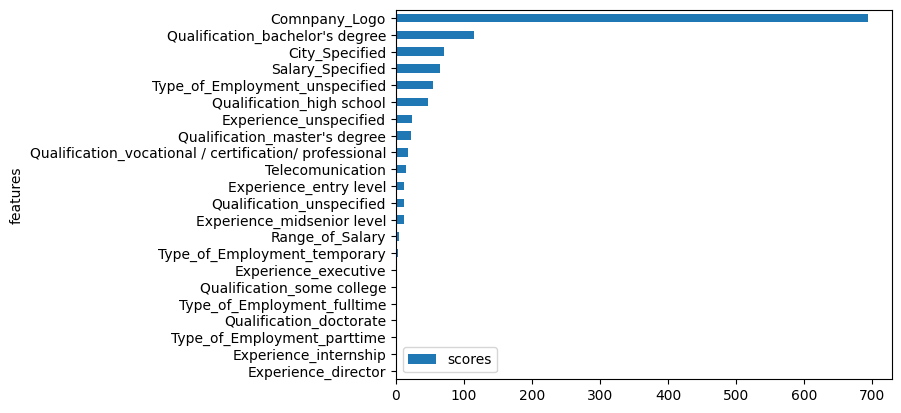

In [19]:
features = non_embed_df.drop(['Fraudulent'], axis=1).columns

selected_ftrs_k = feature_selection(non_embed_df, features, "select_k_best", 30)


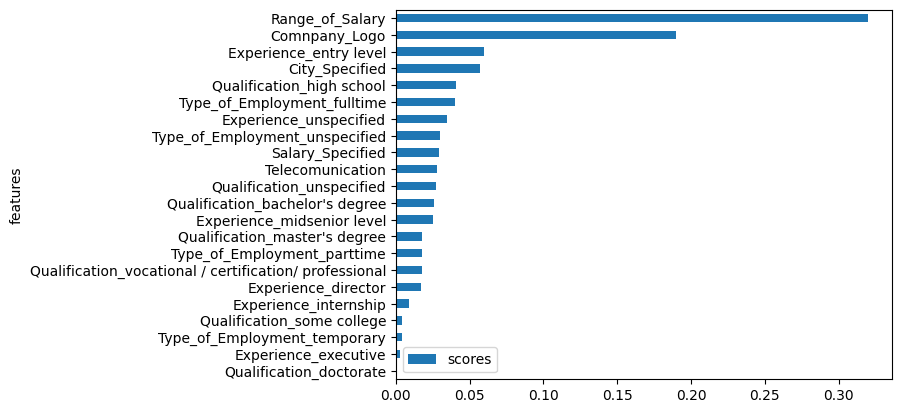

In [20]:
selected_ftrs_k = feature_selection(non_embed_df, features, "select_random_forest", 30)

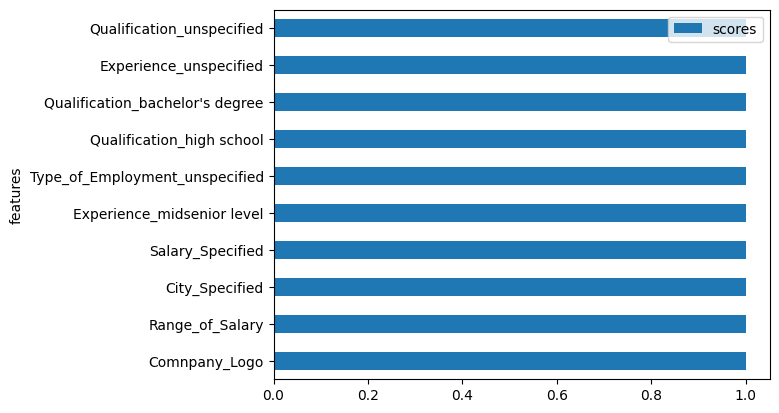

In [22]:
selected_ftrs_k = feature_selection(non_embed_df, features, "select_rfe_with_class_weights", 10)

## Feature Selection (previous idea)

In [ ]:
from sklearn.decomposition import PCA

def dimension_red(df, columns):
    # Example for one embedding column
    for col in columns:
        embedding_col = f'{col}_embed'
        embeddings = np.vstack(df[embedding_col])  # Convert list of arrays to 2D numpy array

        # Reduce to 50 dimensions (adjust based on your needs)
        pca = PCA(n_components=50)
        reduced_embeddings = pca.fit_transform(embeddings)

        # Store back in DataFrame (as list of arrays)
        df[f'{embedding_col}_reduced'] = list(reduced_embeddings)
        df = df.drop(embedding_col , axis=1).reset_index(drop=True)
    return df
    
dimension_red_df = dimension_red(df_aft_enc, columns_for_embedding)

In [96]:
dimension_red_df.head(5)

,Range_of_Salary,Telecomunication,Comnpany_Logo,Fraudulent,Type_of_Employment_fulltime,Type_of_Employment_other,Type_of_Employment_parttime,Type_of_Employment_temporary,Type_of_Employment_unknown,Experience_director,...,Qualification_Vocational / Certification/ Professional,Job Title_embed_reduced,Profile_embed_reduced,Department_embed_reduced,Job_Description_embed_reduced,Requirements_embed_reduced,Job_Benefits_embed_reduced,Type_of_Industry_embed_reduced,Operations_embed_reduced,City_embed_reduced
0,4000070000,0,1,0,False,True,False,False,False,False,...,False,"[-0.067334965, -0.061281376, 0.089948826, -0.2...","[-0.06045939, 0.12829039, 0.01625105, -0.21480...","[-0.6261155, 0.07971919, -0.38180614, -0.47272...","[0.03661868, -0.086809285, -0.06450483, 0.1607...","[-0.10064474, 0.33171985, 0.17074983, 0.037777...","[0.6143662, -0.01821836, -0.0071859546, -0.000...","[0.678962, 0.015128996, -0.0214976, -0.0561460...","[-0.33492365, -0.10431053, -0.056508258, -0.05...","[-0.3146594, 0.55850106, 0.020996824, 0.079793..."
1,4000070000,0,1,0,False,False,False,False,True,False,...,False,"[-0.07651125, -0.046315864, -0.22792043, 0.073...","[-0.2756507, 0.0049986765, -0.01956997, -0.162...","[0.23861426, -0.0038366243, -0.0028273612, -0....","[-0.06815155, 0.25718656, 0.3412344, -0.041710...","[-0.22527453, 0.22319332, -0.15645152, -0.2934...","[0.6143662, -0.01821836, -0.0071859546, -0.000...","[0.678962, 0.015128996, -0.0214976, -0.0561460...","[0.54676056, 0.032579657, 0.03534344, -0.00494...","[0.30525437, 0.03619479, -0.100784674, 0.13957..."
2,4000070000,0,1,0,True,False,False,False,False,False,...,False,"[-0.11384167, -0.26580697, -0.012420163, -0.16...","[-0.251668, 0.07529878, 0.04872378, -0.0443121...","[-0.5744851, 0.68161076, -0.17684408, 0.206163...","[-0.22278774, -0.13669963, -0.24659896, -0.033...","[-0.26367193, 0.26305893, 0.113443494, 0.22952...","[-0.37511194, 0.10060854, 0.51288533, -0.28234...","[-0.35492212, 0.7021694, -0.106899224, 0.06487...","[-0.17006062, -0.5785585, -0.5140943, 0.115691...","[-0.13912654, 0.06369802, -0.074044056, -0.106..."
3,4000070000,0,1,0,True,False,False,False,False,False,...,False,"[-0.14051361, -0.15162005, -0.06160462, -0.177...","[-0.33949825, -0.018820778, -0.06669271, -0.09...","[0.23861426, -0.0038366243, -0.0028273612, -0....","[-0.29488486, 0.31564656, 0.06944589, -0.07779...","[-0.26231557, 0.047799334, -0.09443675, 0.0122...","[-0.47647467, -0.27929786, -0.21437712, 0.0786...","[-0.25174665, -0.3714241, 0.02379439, -0.03559...","[-0.31470618, -0.04606565, 0.45298558, -0.0943...","[-0.036628097, -0.11163938, 0.02156651, 0.0111..."
4,4000070000,0,0,0,False,False,False,False,True,False,...,False,"[-0.10530886, -0.16670753, -0.07648258, -0.121...","[0.8388344, -0.011071868, -0.028537504, 0.0116...","[0.23861426, -0.0038366243, -0.0028273612, -0....","[-0.13537604, 0.11431353, -0.13921344, -0.1366...","[0.9183115, -0.009102605, -0.012788635, 0.0238...","[0.6143662, -0.01821836, -0.0071859546, -0.000...","[0.678962, 0.015128996, -0.0214976, -0.0561460...","[0.54676056, 0.032579657, 0.03534344, -0.00494...","[0.80383193, 0.2841115, 0.27995306, -0.2550547..."


In [110]:
dimension_red_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10656 entries, 0 to 10655
Data columns (total 33 columns):
 #   Column                                                  Non-Null Count  Dtype 
---  ------                                                  --------------  ----- 
 0   Range_of_Salary                                         10656 non-null  int64 
 1   Telecomunication                                        10656 non-null  int64 
 2   Comnpany_Logo                                           10656 non-null  int64 
 3   Fraudulent                                              10656 non-null  int64 
 4   Type_of_Employment_fulltime                             10656 non-null  bool  
 5   Type_of_Employment_other                                10656 non-null  bool  
 6   Type_of_Employment_parttime                             10656 non-null  bool  
 7   Type_of_Employment_temporary                            10656 non-null  bool  
 8   Type_of_Employment_unknown                    

In [113]:
import pandas as pd
from sklearn.feature_selection import SelectKBest, f_classif

def feature_selection(df):
    # 1. Create a feature DataFrame (keeps column names automatically)
    features = pd.DataFrame()

    # Add reduced embeddings
    # for col in columns_for_embedding:
    #     reduced_embeds = pd.DataFrame(np.hstack([np.vstack(df[f'{col}_embed_reduced']) for col in columns_for_embedding]))  # adjust 384 to your reduced dim
    #     features = pd.concat([features, reduced_embeds], axis=1)
    for col in columns_for_embedding:
        embeds = np.vstack(df[f'{col}_embed'])
        reduced_embeds = PCA(n_components=10).fit_transform(embeds)
        features[[f'{col}_pca_{i}' for i in range(10)]] = reduced_embeds

    # Add binary features (no encoding needed)
    features = pd.concat([features, df[['Telecomunication', 'Comnpany_Logo']]], axis=1) #to change the company logo and telecommunication feature name later

    # Add one-hot encoded categoricals
    features = pd.concat([features, df[one_hot_encode_cols]], axis=1)

    # 2. Feature selection (now with automatic name keeping)
    selector = SelectKBest(f_classif, k=10)
    X_selected = selector.fit_transform(features, df['Fraudulent']) #to change the name

    # 3. Get selected feature names (the magic happens here!)
    selected_features = features.columns[selector.get_support()].tolist()

    print("Top 10 features:", selected_features)
    return selected_features

ftr_selected = feature_selection(df_aft_enc)

Top 10 features: ['Job Title_pca_2', 'Profile_pca_0', 'Department_pca_5', 'Job_Description_pca_1', 'Requirements_pca_5', 'Requirements_pca_8', 'Job_Benefits_pca_8', 'Type_of_Industry_pca_6', 'City_pca_3', 'Comnpany_Logo']


In [ ]:
from sklearn.feature_selection import SelectKBest, f_classif

# Prepare all features
embedding_features = np.hstack([np.vstack(df[f'{col}_embed_reduced']) for col in columns_for_embedding])
categorical_features = pd.get_dummies(df[categorical_columns]).values
binary_features = df[['Telecommunication', 'Company_Logo']].values

# Combine all features
X = np.hstack([embedding_features, categorical_features, binary_features])
y = df['Fradulent'].values 

# Select best features
selector = SelectKBest(f_classif, k=100)
X_selected = selector.fit_transform(X, y)

KeyError: 'Job Title_embed_reduced'